# Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
results_df = pd.read_csv ("portfolio_return.csv", header = [0], index_col = 0)
covariance_matrix = pd.read_csv ("portfolio_covariance.csv", header = [0], index_col = 0)

# Portfolio Matrix


In [3]:
results_df

,Expected Return,St. Deviation
CW8.MI,0.133201,0.166646
ETHE,1.030072,1.074457
GC=F,0.115089,0.160264
IDTP.L,0.018112,0.077618
LYTNOW.SW,0.217980,0.254180
SXRC.MU,0.023706,0.390229


In [4]:
covariance_matrix 

,CW8.MI,ETHE,GC=F,IDTP.L,LYTNOW.SW,SXRC.MU
Ticker,,,,,,
CW8.MI,0.027792,0.042735,0.001464,0.002152,0.028558,-0.002456
ETHE,0.042735,1.155353,0.022826,0.010937,0.049319,-0.015792
GC=F,0.001464,0.022826,0.025704,0.004852,0.005854,0.002139
IDTP.L,0.002152,0.010937,0.004852,0.006029,0.003386,0.004709
LYTNOW.SW,0.028558,0.049319,0.005854,0.003386,0.064658,-0.005040
SXRC.MU,-0.002456,-0.015792,0.002139,0.004709,-0.005040,0.152397


# Portfolio Optimazation

In [5]:
# The list of assets 
assets = covariance_matrix.columns.get_level_values(0).unique()

In [6]:
# Number of portfolios to generate 
num_portfolios = 10000
# Risk Free Rate
risk_free_rate = 0.043  
# The minimum weight for each asset (default: 0.01).
min_weight = 0.01
# The number of assets in the portfolio.
num_assets = len(assets)

In [7]:
# Matrix
portfolio_returns = []
portfolio_volatilities = []
sharpe_ratios = []
optimal_weights_all = []

#Efficient frontier line
efficient_frontier_volatilities = []
efficient_frontier_returns = []

In [8]:
def generate_random_weights(num_assets, min_weight=0.01):
    
    # Minimum weights are too large
    if min_weight * num_assets > 1:
        return None  
        
    # loop until the weights are valid
    while True: 
        remaining_weight = 1.0
        weights = np.zeros(num_assets)

        for i in range(num_assets):
            # calculate the maximum possible weight for the current asset.
            max_possible_weight = remaining_weight - (num_assets - i - 1) * min_weight 
            # if the max possible weight is less than the minimum weight, then it is not possible to create a valid weight distribution
            if max_possible_weight < min_weight: 
                break # break the loop and try again
            weight = np.random.uniform(min_weight, max_possible_weight)
            weights[i] = weight
            remaining_weight -= weight

        # check if the remaining weight is close to zero
        if remaining_weight >= 0 and abs(remaining_weight) < 1e-9: 
            return weights # if remaining weight is close to zero, then the weights are valid, so return them
        # if the remaining weight is not close to zero, then the weights are not valid, so try again

In [9]:
# Constraint: sum of weights = 1
def check_weights(weights):
    return np.sum(weights) - 1

In [11]:
 for i in range(num_portfolios):
    # Generate Random Weights:
    weights = generate_random_weights(num_assets, min_weight)
    if weights is None:
        # Skip to the next iteration of the loop
        print("Error: Could not generate valid weights. Skipping portfolio.")
        continue  

    # Calculate Portfolio Return and Volatility:
    portfolio_return = np.sum(weights * results_df['Expected Return'])
    portfolio_volatility = np.sqrt(weights.T @ covariance_matrix @ weights)

    # Calculate Sharpe Ratio:
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Store Results:
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)
    sharpe_ratios.append(sharpe_ratio)

    # Optimization for a specific target return (efficient frontier) 
    target_return = np.linspace(min(results_df['Expected Return']), max(results_df['Expected Return']), num_portfolios)[i]
     
    def portfolio_variance(weights, covariance_matrix):
        return weights.T @ covariance_matrix @ weights
    
    def return_constraint(weights, expected_returns, target_return):
        return np.sum(weights * expected_returns) - target_return

    constraints = ({'type': 'eq', 'fun': check_weights},
                   {'type': 'eq', 'fun': lambda w: return_constraint(w, results_df['Expected Return'], target_return)})  # Target return constraint

    bounds = [(0, 1)] * num_assets
    initial_weights = np.array([1/num_assets] * num_assets)

    result = minimize(portfolio_variance, initial_weights, args=(covariance_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x
    optimal_weights_all.append(optimal_weights)

Text(0.5, 1.0, 'The Volatility and Expected Return for Random Portfolio')

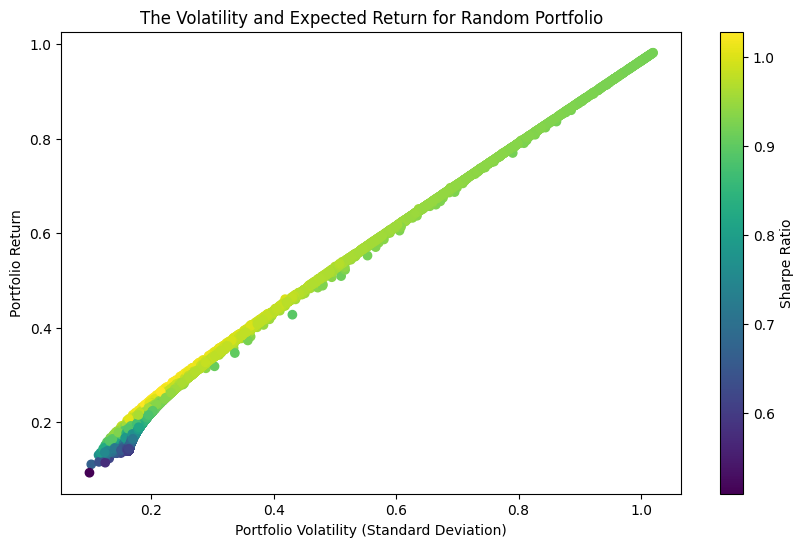

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratios, cmap='viridis', label='Random Portfolios') #Random portfolios
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('The Volatility and Expected Return for Random Portfolio')

In [13]:
for weights in optimal_weights_all:
  portfolio_return = np.sum(weights * results_df['Expected Return'])
  portfolio_volatility = np.sqrt(weights.T @ covariance_matrix @ weights)
  efficient_frontier_returns.append(portfolio_return)
  efficient_frontier_volatilities.append(portfolio_volatility)

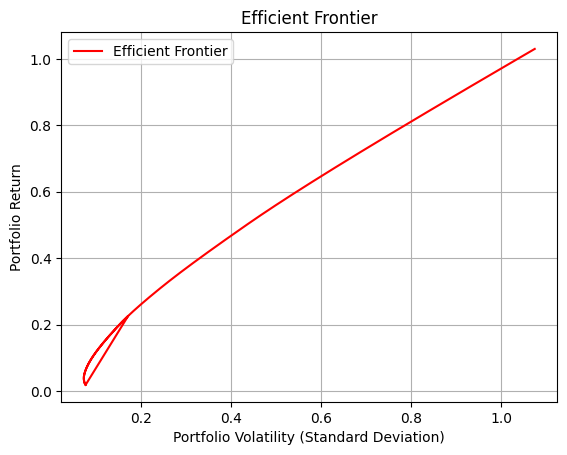

In [14]:
plt.plot(efficient_frontier_volatilities, efficient_frontier_returns, color='red', label='Efficient Frontier')
plt.legend()
plt.grid(True)
plt.xlabel('Portfolio Volatility (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.show()

In [15]:
max_sharpe_ratio_index = np.argmax(sharpe_ratios)

In [16]:
# Get the optimal weights for the maximum Sharpe Ratio portfolio:
optimal_weights = optimal_weights_all[max_sharpe_ratio_index]

In [17]:
portfolio_return = np.sum(optimal_weights* results_df['Expected Return'])
portfolio_variance = optimal_weights.T @ covariance_matrix @ optimal_weights
portfolio_std_dev = np.sqrt(portfolio_variance)
beta= (portfolio_return - risk_free_rate) / (0.13 -  risk_free_rate)
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

In [23]:
print("\nPortfolio with Maximum Sharpe Ratio:")
print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_ratio_index]:.4f}")
print(f"Portfolio Annual Return: {portfolio_return:.2%}")
print(f"Portfolio Variance: {portfolio_variance:.2%}")
print(f"Portfolio Standard Deviation: {portfolio_std_dev:.2%}")
print(f"BETA: {beta:.2f}")


Portfolio with Maximum Sharpe Ratio:
Sharpe Ratio: 1.0288
Portfolio Annual Return: 67.71%
Portfolio Variance: 40.57%
Portfolio Standard Deviation: 63.69%
BETA: 7.29


In [19]:
# Create a DataFrame to display the optimal weights:
optimal_weights_df_sharpe = pd.DataFrame({'Asset': assets, 'Optimal Weight (Sharpe)': optimal_weights})

In [20]:
print("\nOptimal Weights (Maximum Sharpe Ratio Portfolio):\n", optimal_weights_df_sharpe.to_string(float_format=lambda x: f"{x:.4f}"))


Optimal Weights (Maximum Sharpe Ratio Portfolio):
        Asset  Optimal Weight (Sharpe)
0     CW8.MI                   0.0000
1       ETHE                   0.5653
2       GC=F                   0.0000
3     IDTP.L                   0.0000
4  LYTNOW.SW                   0.4347
5    SXRC.MU                   0.0000


In [21]:
optimal_weights_df_sharpe.to_csv("optima;_Weights.csv")